### Libraries

In [1]:
import cooler
import cooltools
import bioframe
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import venn

from dots_common import _2_step_loop_separation, make_loops_df, make_anchors_df
import dots_common

from coolpuppy import coolpup

import os

/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/micromamba/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


### Prep. Analysis Data (Call loops, prepare expected calculations etc)

In [2]:
nproc = 6
resolution = 10_000
threshold = 1 #log2 threshold for loops strengths
samples = ['t0', 't12', 't30', 't60']
clrs_ = [cooler.Cooler(f"/home/carlos/oldies/manuscripts/notebooks/matrices/{sample_name}_q30.mcool::resolutions/{resolution}") for sample_name in samples]

accepted_range = 20_000 # tolerated range for anchor flanks, should be an integer and multiplier of resolution

In [3]:
hg38_chromsizes = bioframe.fetch_chromsizes("hg38")
hg38_cens = bioframe.fetch_centromeres("hg38")
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clrs_[0].chromnames].reset_index()

In [4]:
# check if files exist for expected calculations
if sum([os.path.exists(f"/home/carlos/oldies/manuscripts/review/expected/expected_{sample_name}.{resolution}.arms.tsv") for sample_name in samples]) == 4:
    expected_ = [pd.read_csv(f"/home/carlos/oldies/manuscripts/review/expected/expected_{sample_name}.{resolution}.arms.tsv", sep='\t') for sample_name in samples]
else:
    expected_ = [
        cooltools.expected_cis(
            clr,
            view_df=hg38_arms,
            nproc=nproc,
        )
        for clr in clrs_
    ]
    for i, expected_df in enumerate(expected_):
        expected_df.to_csv(f"/home/carlos/oldies/manuscripts/review/expected/expected_{samples[i]}.{resolution}.arms.tsv", index=False, sep='\t')

# check if files exist for loop calls
if sum([os.path.exists(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{sample_name}.{resolution}.arms.tsv") for sample_name in samples]) == 4:
    dots_df_ = [pd.read_csv(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{sample_name}.{resolution}.arms.tsv", sep='\t') for sample_name in samples]
else:
    dots_df_ = [
        cooltools.dots(
            clr,
            expected=expected,
            view_df=hg38_arms,
            max_loci_separation = 10_000_000,
            nproc=nproc,
            cluster_filtering=True,
        ) for clr, expected in zip(clrs_, expected_)
    ]

    for i, _df in enumerate(dots_df_):
        _df.to_csv(f"/home/carlos/oldies/manuscripts/review/loop_calls/loops_{samples[i]}.{resolution}.arms.tsv", index=False, sep='\t')

### LOOPS ~ Separation into COMMON, SPECIFIC loops

Loops are identified with cooltools dots methods.
Common loops are identified if a loop is identified in both samples, which show loop properties are satisfied.

We are going to implement 2 step procedure to identify "Specific" loops.
There are two objectives to satisfy for specific loops (Loop properties that satify kernels and loop strength):
1. A loop must be specific to a sample if loop properties are satisfied in only one of the samples.
2. Interaction coordinates from step 1, should only be enriched in signal intensity in the identified sample.

In [56]:
loops, anchors = _2_step_loop_separation(
    dots_df_[0], dots_df_[1], 
    clrs_[0], clrs_[1],
    expected_[0], expected_[1],
    view_df=hg38_arms,
    merge_common = True, accepted_range=accepted_range, threshold = threshold, nproc=nproc, resolution=resolution)

/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


In [57]:
for k,v in loops.items():
    print(k, v.shape)
    df_out = v.copy()
    # reorder columns
    df_out['end1'] = df_out['start1'] + resolution
    df_out['end2'] = df_out['start2'] + resolution
    df_out = df_out[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
    df_out.iloc[:, :6].to_csv(f"v3/unibind_data/loops_{k}.tsv", index=False, sep="\t")

for k,v in anchors.items():
    print(k, v.shape)
    df_out = v.copy()
    df_out['end'] = df_out['start'] + resolution
    df_out.to_csv(f"v3/unibind_data/anchors_{k}.tsv", index=False, sep="\t")

specific_loops1 (1134, 4)
specific_loops2 (930, 4)
common_loops (5530, 4)
specific_anchors1 (1094, 2)
specific_anchors2 (863, 2)
common_anchors (8638, 2)


In [72]:
df = make_loops_df(loops)
t0_t12_df = df.copy()
t0_t12_anchors_df = make_anchors_df(anchors)

In [73]:
for loop_type in df['type'].unique():
    current_df = df[df['type'] == loop_type]

    print(loop_type, current_df.shape)
    print(current_df['length'].median(), current_df['length'].mean())

print(f"All loops\n{df['length'].median()} {df['length'].mean()}", df.shape)

specific_loops1 (1134, 8)
240000.0 328571.4285714286
specific_loops2 (930, 8)
260000.0 362612.9032258064
common_loops (5530, 8)
220000.0 296660.03616636526
All loops
230000.0 309502.2386094285 (7594, 8)


### LOOPS ~ APA

In [74]:
apa_flank = 100_000

In [75]:

pups_ = [
	coolpup.pileup(clr, df, features_format='bedpe', view_df=hg38_arms, expected_df=expected,
							groupby=['type'], flank=apa_flank, nproc=nproc, local=False)
							for clr, expected in zip(clrs_[:2], expected_)
]

INFO:coolpuppy:('chr4_p', 'chr4_p'): 78
INFO:coolpuppy:('chr2_p', 'chr2_p'): 162
INFO:coolpuppy:('chr1_p', 'chr1_p'): 156
INFO:coolpuppy:('chr3_p', 'chr3_p'): 102
INFO:coolpuppy:('chr5_p', 'chr5_p'): 113
INFO:coolpuppy:('chr6_p', 'chr6_p'): 195
INFO:coolpuppy:('chr4_q', 'chr4_q'): 109
INFO:coolpuppy:('chr3_q', 'chr3_q'): 181
INFO:coolpuppy:('chr2_q', 'chr2_q'): 153
INFO:coolpuppy:('chr1_q', 'chr1_q'): 273
INFO:coolpuppy:('chr6_q', 'chr6_q'): 166
INFO:coolpuppy:('chr8_p', 'chr8_p'): 58
INFO:coolpuppy:('chr7_p', 'chr7_p'): 162
INFO:coolpuppy:('chr5_q', 'chr5_q'): 296
INFO:coolpuppy:('chr9_p', 'chr9_p'): 69
INFO:coolpuppy:('chr10_p', 'chr10_p'): 79
INFO:coolpuppy:('chr11_p', 'chr11_p'): 93
INFO:coolpuppy:('chr12_p', 'chr12_p'): 70
INFO:coolpuppy:('chr8_q', 'chr8_q'): 135
INFO:coolpuppy:('chr7_q', 'chr7_q'): 125
INFO:coolpuppy:('chr9_q', 'chr9_q'): 145
INFO:coolpuppy:('chr10_q', 'chr10_q'): 94
INFO:coolpuppy:('chr11_q', 'chr11_q'): 124
INFO:coolpuppy:('chr12_q', 'chr12_q'): 190
INFO:coolpu

In [76]:
def min_max_comp(data__):
	vmin = []
	vmax = []
	for data_ in data__:
		data_ = data_.data
		for data in data_:
			vmin.append(np.nanmin(data))
			vmax.append(np.nanmax(data))
	vmax = np.nanmax(vmax)
	vmin = np.nanmin(vmin)

	vmax = 2 ** (np.max(np.abs(np.log2([vmin, vmax]))))

	if vmax >= 1:
		vmin = 2 ** -np.log2(vmax)
	return vmin, vmax

In [77]:
def get_corner_scores(data, n_bins):
    center_idx = data.shape[0] // 2
    center_score = data[center_idx, center_idx]
    tl = np.nanmean(data[:n_bins, :n_bins]) 
    br = np.nanmean(data[-n_bins:, -n_bins:])
    tr = np.nanmean(data[:n_bins, -n_bins:])
    bl = np.nanmean(data[-n_bins:, :n_bins])

    return [
        center_score / tl, 
        center_score / tr, 
        center_score / bl, 
        center_score / br]

def central_score(data, n):
    c = data.shape[0] // 2
    return np.nanmean(data[c - n // 2 : c + n // 2 + 1, c - n // 2 : c + n // 2 + 1])

In [78]:
corner_size = 6
central_size = 1

In [79]:
for pup in pups_:
    pup['central_score'] = pup.apply(
                    lambda x: central_score(x['data'], central_size), axis=1
                )

for pup in pups_:
    pup['corner_scores'] = pup.apply(
                    lambda x: get_corner_scores(x['data'], corner_size), axis=1
                )

In [80]:
pups_reordered = []
#re_order = ["common_loops1", "common_loops2", "specific_loops1", "specific_loops2", "all"] # order if common loops are not merged
re_order = ["common_loops", "specific_loops1", "specific_loops2", "all"]

for pup in pups_:
    pup_df = pup.copy()

    pup_df.set_index("type", inplace=True)
    pup_df = pup_df.reindex(re_order)
    pup_df["type"] = pup_df.index
    pup_df.reset_index(drop=True, inplace=True)
    pups_reordered.append(pup_df)

In [81]:
from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "white", "#C42021"], N=256)
height =6
sample_names = ["Control", "12min"]

0    /home/carlos/oldies/manuscripts/notebooks/matr...
1    /home/carlos/oldies/manuscripts/notebooks/matr...
2    /home/carlos/oldies/manuscripts/notebooks/matr...
3    /home/carlos/oldies/manuscripts/notebooks/matr...
Name: clr, dtype: object
0    /home/carlos/oldies/manuscripts/notebooks/matr...
1    /home/carlos/oldies/manuscripts/notebooks/matr...
2    /home/carlos/oldies/manuscripts/notebooks/matr...
3    /home/carlos/oldies/manuscripts/notebooks/matr...
Name: clr, dtype: object
0    /home/carlos/oldies/manuscripts/notebooks/matr...
1    /home/carlos/oldies/manuscripts/notebooks/matr...
2    /home/carlos/oldies/manuscripts/notebooks/matr...
3    /home/carlos/oldies/manuscripts/notebooks/matr...
Name: clr, dtype: object
0    /home/carlos/oldies/manuscripts/notebooks/matr...
1    /home/carlos/oldies/manuscripts/notebooks/matr...
2    /home/carlos/oldies/manuscripts/notebooks/matr...
3    /home/carlos/oldies/manuscripts/notebooks/matr...
Name: clr, dtype: object


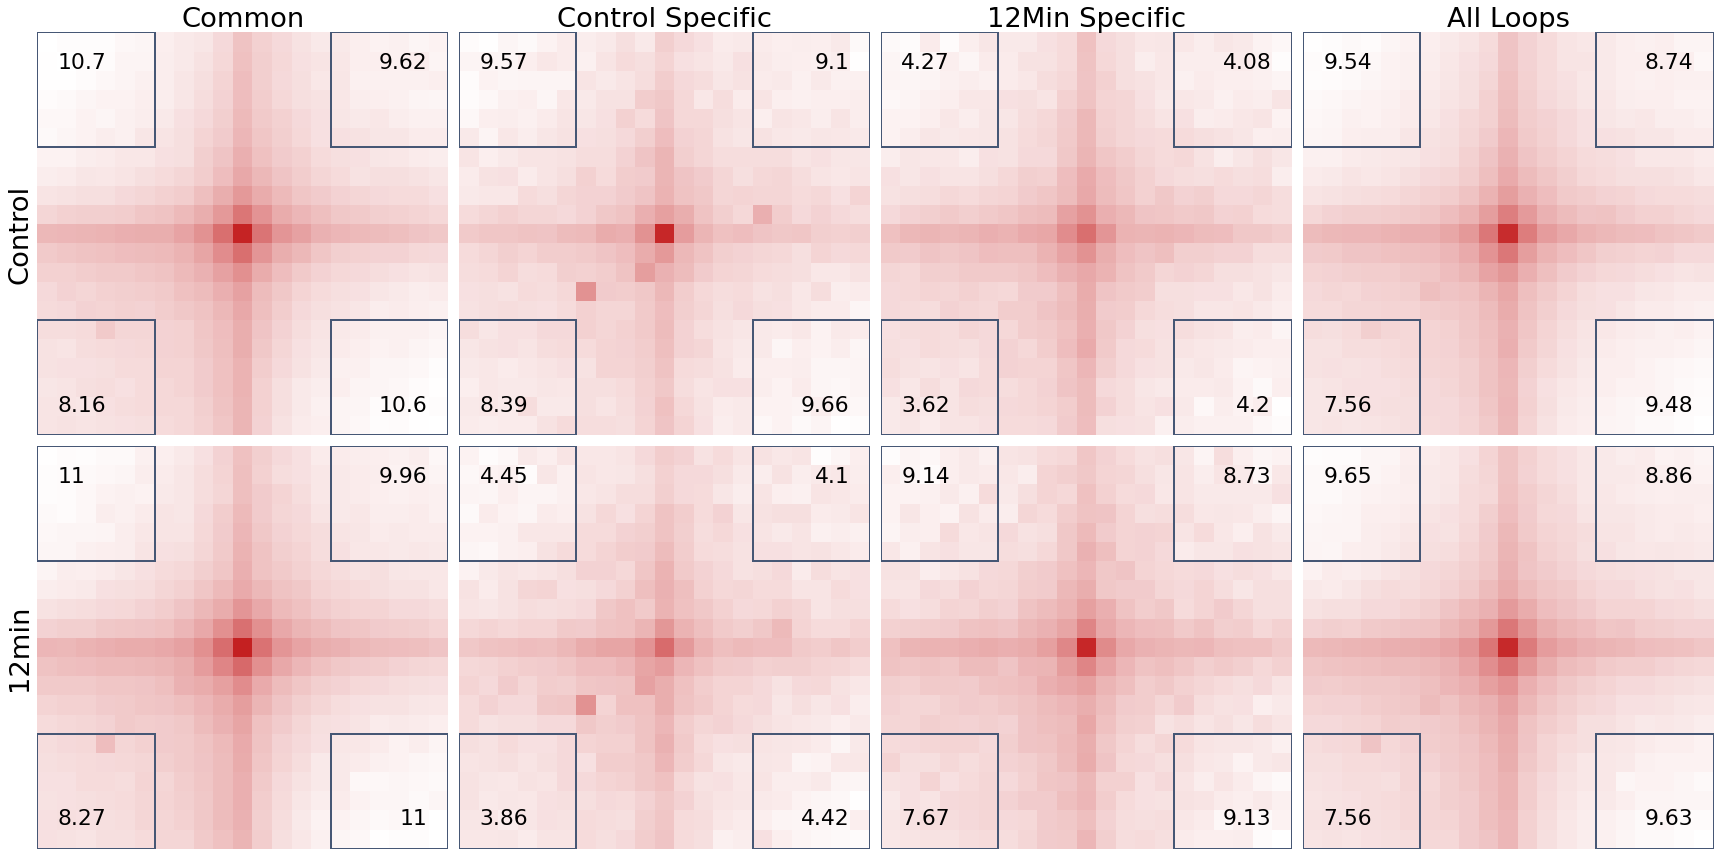

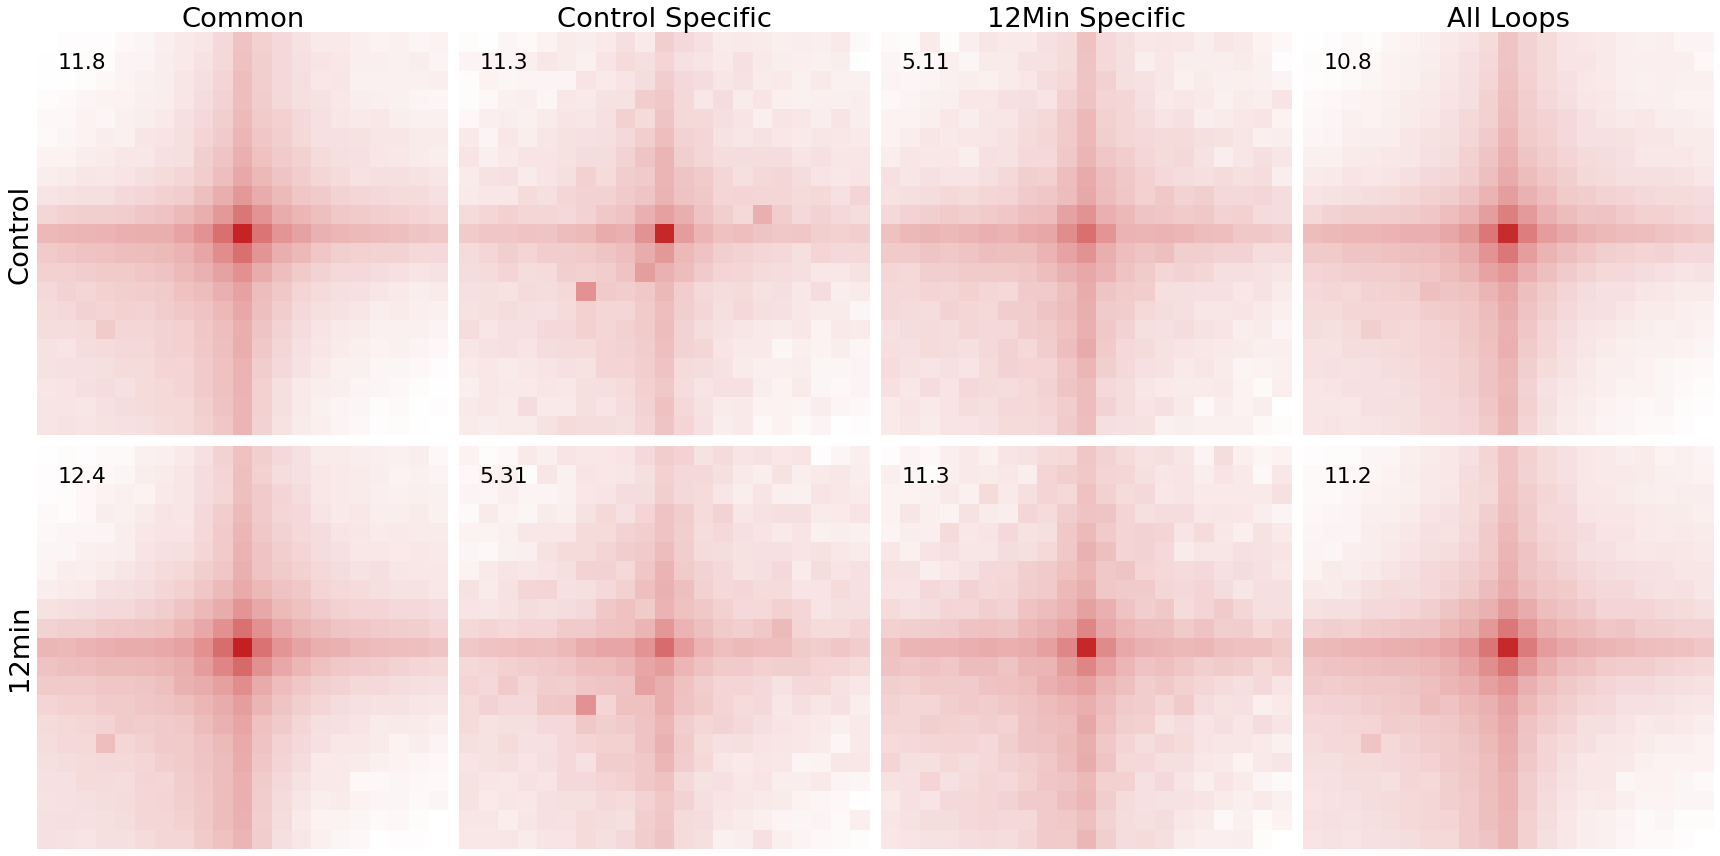

In [82]:
from dots_common import add_scores
for scores_type in ["corner_scores", "central_score"]:

      vmin, vmax = min_max_comp(pups_reordered)

      norm = LogNorm(vmin=vmin, vmax=vmax)
      fig, axs = plt.subplots(
            ncols=4,
            nrows=len(pups_reordered),
            figsize=(24, height*2),
            sharex=True,
            sharey=True,
      )

      font_scale = 2

      types_dict = {
            "specific_loops1": "Control Specific", 
            "specific_loops2": "12Min Specific", 
            "common_loops": "Common",  
            "all": "All Loops"}

      for i, pup in enumerate(pups_reordered):
            print(pup.clr)
            types =  pup.type

            for idx, ax in enumerate(axs[i, :]):
                  s = sns.heatmap(
                        pup.iloc[idx].data,
                        cmap=cmp,
                        norm=norm,
                        ax=ax,
                        cbar=False,
                        xticklabels=False,
                        yticklabels=False,
                  )
                  current_type = types[idx]
                  if i == 0:
                        s.set_title(types_dict[current_type], fontsize=2.5 * (4.94 + height))
                  if idx == 0:
                        s.set_ylabel(sample_names[i], fontsize=2.5 * (4.94 + height))
                  else:
                        s.set_ylabel("")
                  mtx_size = pup.iloc[idx].data.shape[0]
                        
                  score_central = pup.central_score[idx]
                  score_corner = pup.corner_scores[idx]
                  if scores_type == "corner_scores":
                        dots_common.add_scores(scores_type, score_corner, ax, mtx_size, corner_size, font_scale = 2, height = 6)
                  elif scores_type == "central_score":
                        dots_common.add_scores(scores_type, score_central, ax, mtx_size, central_size, font_scale = 2, height = 6)

      fig.set_tight_layout(True)
      fig.savefig(f"v3/reworked_figs/fig4e_{scores_type}.svg")
      fig.savefig(f"v3/reworked_figs/fig4e_{scores_type}.png", dpi = 300)

### LOOPS ~ VENN

In [ ]:
def prepare_merged_anchor(dots_df_, min_dist=50_000):
    loops_df_list = [df.iloc[:, :6] for df in dots_df_]
    all_dots = pd.concat(loops_df_list).drop_duplicates()
    anchors1 = all_dots.iloc[:, :3]
    anchors2 = all_dots.iloc[:, 3:6]
    anchors1.columns = ["chrom", "start", "end"]
    anchors2.columns = ["chrom", "start", "end"]
    all_anchors = pd.concat([anchors1, anchors2]).drop_duplicates().reset_index(drop=True)
    all_anchors = bioframe.merge(all_anchors, min_dist=min_dist)
    return all_anchors, loops_df_list

def overlap_to_all_anchors(loops_df_list, all_anchors):
    for i, df in enumerate(loops_df_list):
        anchors1 = df.iloc[:, :3]
        anchors2 = df.iloc[:, 3:6]
        anchors1.columns = ["chrom", "start", "end"]
        anchors2.columns = ["chrom", "start", "end"]

        overlap1 = bioframe.overlap(anchors1, all_anchors, return_index=True)
        overlap2 = bioframe.overlap(anchors2, all_anchors, return_index=True)

        loops_df_list[i].loc[:, "anchor1"] = overlap1.loc[:, "index_"]
        loops_df_list[i].loc[:, "anchor2"] = overlap2.loc[:, "index_"]

        loops_df_list[i].sort_values(["anchor1", "anchor2"], inplace=True)
        loops_df_list[i].drop_duplicates(subset=["anchor1", "anchor2"], inplace=True)

    return loops_df_list

min_dist = 50_000 # 4-way comparison tolerance for venn, we use 20kb tolerance for pairwise comparison for any other analysis

anchors_all, loops_all = prepare_merged_anchor(dots_df_= dots_df_, min_dist = min_dist)
loops_all = overlap_to_all_anchors(loops_all, anchors_all)

/tmp/ipykernel_66315/2385777116.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


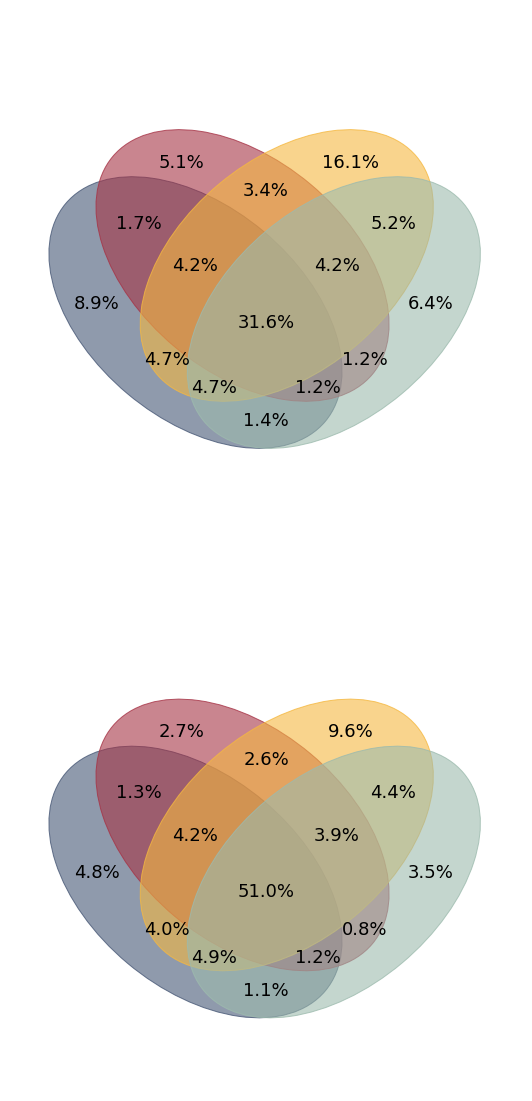

In [19]:
import venn
cmap = ["#465775", "#A63446", "#F5B841", "#9DBBAE"]
alpha = 0.60

# LOOPS
venn_df_all = {}

for dots_df, s in zip(loops_all, samples):

    rows_as_tuples = [f"{row[6]}-{row[7]}" for index, row in dots_df.iterrows()]
    venn_df_all[s] = set(rows_as_tuples)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 20),
    gridspec_kw={"hspace": 0.1},
)
v = venn.venn(
    venn_df_all,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
    ax=ax[0],
    alpha=alpha,
)


# draw venn diagram for anchors

anchors_dfs_dict = {}
for dots_df, s in zip(loops_all, samples):
    anchors_dfs_dict[s] = set()
    for i, entry in dots_df.iterrows():
        anchors_dfs_dict[s].add(entry[6])
        anchors_dfs_dict[s].add(entry[7])

venn.venn(
    anchors_dfs_dict,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
	ax=ax[1],
    alpha=alpha,
)

plt.tight_layout()
plt.savefig("v3/reworked_figs/loops_anchors_venn.svg", bbox_inches='tight')
plt.savefig("v3/reworked_figs/loops_anchors_venn.png", dpi=600, bbox_inches='tight')

### Loops ~ Transition (Bar plots)

In [20]:
transition_data = {}

for i, i_sample in enumerate(samples[:-1]):
    for j, j_sample in enumerate(samples[1:]):
        if j != i:
            continue
        idx_sample_i = samples.index(i_sample)
        idx_sample_j = samples.index(j_sample)
        dots_df_i = dots_df_[idx_sample_i].copy()
        dots_df_j = dots_df_[idx_sample_j].copy()
        loops, anchors = _2_step_loop_separation(
            dots_df_i, dots_df_j, 
            clrs_[idx_sample_i], clrs_[idx_sample_j],
            expected_[idx_sample_i], expected_[idx_sample_j],
            view_df=hg38_arms, 
            merge_common = True, accepted_range=accepted_range, threshold = threshold, resolution=resolution, nproc=nproc)
        transition_data[f"{i_sample}_{j_sample}"] = (loops, anchors)
        for k,v in anchors.items():
            v.to_csv(f"v3/spec_anchors/anchors_{k}_{i_sample}_{j_sample}.tsv", index=False, sep="\t")
        for k,v in loops.items():
            v.to_csv(f"v3/spec_loops/loops_{k}_{i_sample}_{j_sample}.tsv", index=False, sep="\t")

/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


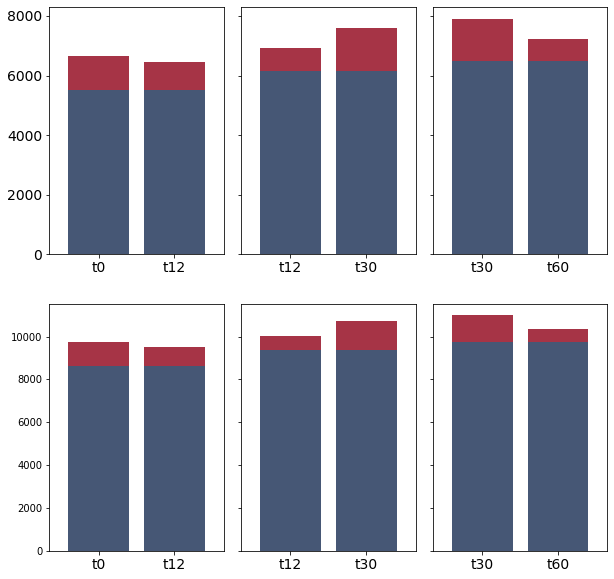

In [21]:
fig, axs = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10, 10),
    sharey="row",
    gridspec_kw={"wspace": 0.1}
)

# plot loops
for i, i_sample in enumerate(samples[:-1]):
    for j, j_sample in enumerate(samples[1:]):
        if j != i:
            continue
        
        labels = (i_sample, j_sample)
        weights_loops = {
        "Common": (
            transition_data[f"{i_sample}_{j_sample}"][0]["common_loops"].shape[0],

        ),
        "Unique": (
            transition_data[f"{i_sample}_{j_sample}"][0]["specific_loops1"].shape[0],
            transition_data[f"{i_sample}_{j_sample}"][0]["specific_loops2"].shape[0],
        ),
        }

        df = pd.DataFrame(weights_loops, index=labels)
        
        ax=axs[0, i]
        df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
        ax.set_xticklabels(labels=labels, fontsize=14)
        ax.tick_params(axis='y', labelsize=14)

        weights_anchors = {
        "Below": (
            transition_data[f"{i_sample}_{j_sample}"][1]["common_anchors"].shape[0],

        ),
        "Above": (
            transition_data[f"{i_sample}_{j_sample}"][1]["specific_anchors1"].shape[0],
            transition_data[f"{i_sample}_{j_sample}"][1]["specific_anchors2"].shape[0],
        ),
        }

        df = pd.DataFrame(weights_anchors, index=labels)
        ax=axs[1, i]
        df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
        ax.set_xticklabels(labels=labels, fontsize=14)

fig.savefig("v3/reworked_figs/fig_transition.svg", bbox_inches='tight')
fig.savefig("v3/reworked_figs/fig_transition.png", dpi=300, bbox_inches='tight')

### LOOPS ~ REPAIR 

In [22]:
import data_handlers
import bbi

In [23]:
loop_types = ["common_loops", "specific_loops1", "specific_loops2"]

flank_size = 100_000
nbins_main = 320
nbins_flank = 100

from scipy.ndimage import gaussian_filter1d

plot_dfs = []

for i, loop_type in enumerate(loop_types):
    df_now = t0_t12_df.loc[t0_t12_df['type'] == loop_type].copy()

    for j, data_name in enumerate(['xr-cpd-over-sim', 'xr-64-over-sim', 'ctcf', 'dnase', 'faire', 'ds-cpd-over-sim', 'ds-64-over-sim', 'rep-eff-cpd', 'rep-eff-64']):
        
        if data_name in ['xr-cpd-over-sim', 'xr-64-over-sim', 'rep-eff-cpd', 'rep-eff-64']:
        
            start_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1 - flank_size, df_now.start1, nbins_flank) / data_handlers.MEANS_BW[data_name]
            end_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom2, df_now.start2 + resolution, df_now.start2 + resolution + flank_size, nbins_flank) / data_handlers.MEANS_BW[data_name]
            main_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1, df_now.start2 + resolution, nbins_main) / data_handlers.MEANS_BW[data_name]

            stack = np.hstack([start_data, main_data, end_data])
            
            stack = np.nanmean(stack, axis=0)
            stack = gaussian_filter1d(stack, 2)
            
            plot_df = pd.DataFrame(stack).melt()
            plot_df['variable'] = np.arange(plot_df.shape[0])
            plot_df['type'] = loop_type
            plot_df['data_name'] = data_name
            plot_dfs.append(plot_df)
        
        else:
            anchors1 = df_now.iloc[:, :3]
            anchors1['loop_idx'] = df_now.index
            anchors2 = df_now.iloc[:, 3:6]
            anchors2['loop_idx'] = df_now.index
            anchors1.columns = ["chrom", "start", "end", "loop_idx"]
            anchors2.columns = ["chrom", "start", "end", "loop_idx"]
            all_anchors = pd.concat([anchors1, anchors2]).reset_index(drop=True)
            
            main_data = bbi.stackup(data_handlers.BWS[data_name], all_anchors.chrom, all_anchors.start, all_anchors.end, 1) / data_handlers.MEANS_BW[data_name]

            plot_df = pd.DataFrame(main_data).melt()
            plot_df['variable'] = np.arange(plot_df.shape[0])
            plot_df['type'] = loop_type
            plot_df['data_name'] = data_name
            plot_df['loop_idx'] = all_anchors['loop_idx']

            left_anchors_values = plot_df.iloc[:len(anchors1), 1].to_numpy()
            right_anchors_values = plot_df.iloc[len(anchors1):, 1].to_numpy()
            mean_vals = (left_anchors_values + right_anchors_values) / 2
            plot_df = plot_df.iloc[:len(anchors1)].copy()
            plot_df['value'] = mean_vals
            plot_dfs.append(plot_df)

plot_df_loops = pd.concat(plot_dfs).reset_index(drop=True)

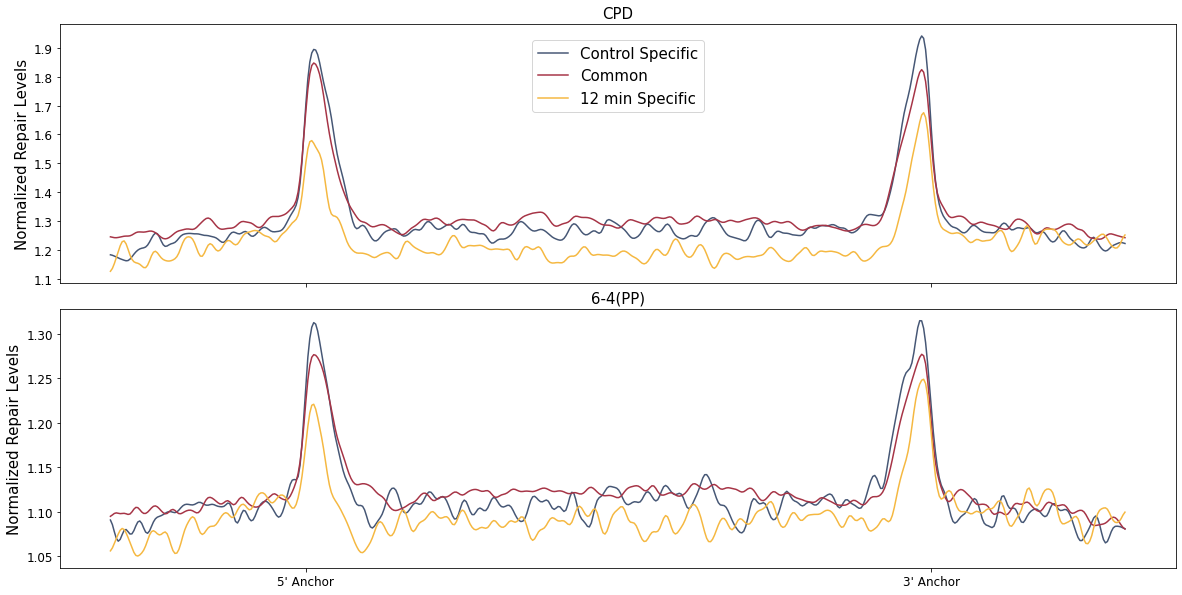

In [24]:
grid_specs = {
    'hspace': 0.1, 'wspace': 0.1
}

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex='col', gridspec_kw=grid_specs)

s_colors = ['#465775', '#A63446', '#F5B841']


# data_name_mapping_loops = {
#     'xr-cpd-over-sim' : 'CPD',
#     'xr-64-over-sim' : '6-4(PP)'
# }

data_name_mapping_loops = {
    'xr-cpd-over-sim' : 'CPD',
    'xr-64-over-sim' : '6-4(PP)'
}


loop_categories = ['specific_loops1', 'common_loops', 'specific_loops2']

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[i]
    df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()

    # set plot order for loop types
    df_now.type = pd.Categorical(df_now.type, categories=loop_categories, ordered=True)

    sns.lineplot(data=df_now, x='variable', y='value', hue='type', palette=s_colors, ax=ax)

    # set legend to middle
    if i == 0:
        ax.legend(['Control Specific', 'Common',  '12 min Specific'], loc='center', bbox_to_anchor=(0.5, 0.8), ncol=1, fontsize=15)
    else:
        ax.get_legend().remove()
    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Normalized Repair Levels', fontsize=15)
    ax.set_xlabel('')

    ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

fig.savefig("v3/reworked_figs/fig4f.svg", bbox_inches='tight')
fig.savefig("v3/reworked_figs/fig4f.png", dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

specific_loops1 vs. specific_loops2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.529e-15 U_stat=5.523e+05
common_loops vs. specific_loops1: Mann-Whitney-Wilcoxon test two-sided, P_val:4.298e-02 U_stat=2.623e+06
common_loops vs. specific_loops2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.643e-16 U_stat=2.642e+06
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

specific_loops1 vs. specific_loops2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.240e-07 U_stat=5.971e+05
common_loops vs. specific_loops1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.909e-01 U_stat=3.073e+06
common_loops vs. specific_loops2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.408e-

/tmp/ipykernel_66315/1627990138.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


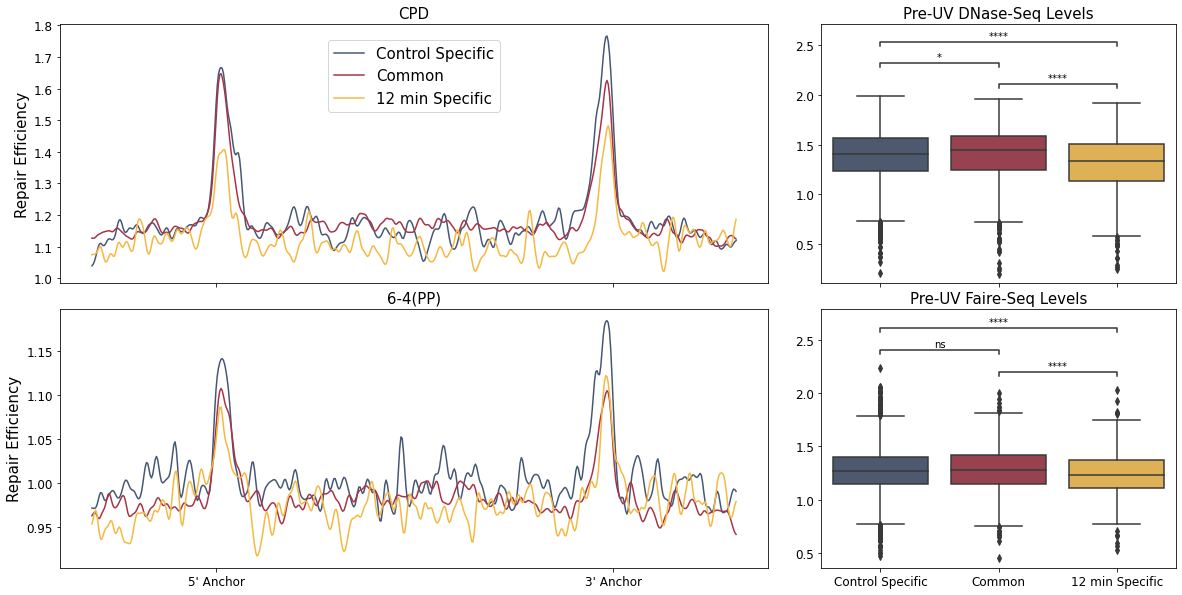

In [25]:
# grid_specs = {
#     'width_ratios': [1, .5, .5],
#     'height_ratios': [1, 1],
# # set spacing
#     'hspace': 0.1, 'wspace': 0.1
# }

#fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex='col', gridspec_kw=grid_specs)

grid_specs = {
    'width_ratios': [1, .5],
    'height_ratios': [1, 1],
# set spacing
    'hspace': 0.1, 'wspace': 0.1
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex='col', gridspec_kw=grid_specs)

s_colors = ['#465775', '#A63446', '#F5B841']

data_name_mapping_loops = {
    'rep-eff-cpd' : 'CPD',
    'rep-eff-64' : '6-4(PP)'
}


loop_categories = ['specific_loops1', 'common_loops', 'specific_loops2']

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[i,0]
    df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()

    # set plot order for loop types
    df_now.type = pd.Categorical(df_now.type, categories=loop_categories, ordered=True)

    sns.lineplot(data=df_now, x='variable', y='value', hue='type', palette=s_colors, ax=ax)

    # set legend to middle
    if i == 0:
        ax.legend(['Control Specific', 'Common',  '12 min Specific'], loc='center', bbox_to_anchor=(0.5, 0.8), ncol=1, fontsize=15)
    else:
        ax.get_legend().remove()
    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Repair Efficiency', fontsize=15)
    ax.set_xlabel('')

    ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

# data_name_mapping_anchors = {
#     'ds-cpd-over-sim' : 'CPD - Normalized Damage Levels',
#     'ds-64-over-sim' : '6-4PP - Normalized Damage Levels',
# }
# anchor_categories = ['specific_loops1', 'common_loops',  'specific_loops2']
# for i, data_name in enumerate(data_name_mapping_anchors):
#     ax = axs[i,1]
#     df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()
#     #df_now.type = pd.Categorical(df_now.type, categories=anchor_categories, ordered=True)
#     sns.boxplot(data=df_now, x='type', y='value', palette=s_colors, ax=ax, showfliers=True)

#     pairs = [
#     ('specific_loops1', 'specific_loops2'),
#     ('specific_loops1', 'common_loops'),
#     ('specific_loops2', 'common_loops')
#     ]
    
#     from statannotations.Annotator import Annotator

#     annotator = Annotator(ax, pairs, data=df_now, x='type', y='value')
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#     annotator.apply_and_annotate()

#     ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
#     ax.set_ylabel('')
#     ax.set_xlabel('')

#     ax.set_xticklabels(['Control Specific', 'Common',  '12 min Specific'], fontsize=15)

#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.tick_params(axis='both', which='minor', labelsize=12)

data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels',
}
anchor_categories = ['specific_loops1', 'common_loops',  'specific_loops2']
for i, data_name in enumerate(data_name_mapping_anchors):
    #ax = axs[i,2]
    ax = axs[i,1]
    df_now = plot_df_loops.loc[plot_df_loops['data_name'] == data_name].copy()
    #df_now.type = pd.Categorical(df_now.type, categories=anchor_categories, ordered=True)
    sns.boxplot(data=df_now, x='type', y='value', palette=s_colors, ax=ax, showfliers=True)

    pairs = [
    ('specific_loops1', 'specific_loops2'),
    ('specific_loops1', 'common_loops'),
    ('specific_loops2', 'common_loops')
    ]
    
    from statannotations.Annotator import Annotator

    annotator = Annotator(ax, pairs, data=df_now, x='type', y='value')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('')

    ax.set_xticklabels(['Control Specific', 'Common',  '12 min Specific'], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()
fig.savefig("v3/reworked_figs/fig4f_supp.svg", bbox_inches='tight')
fig.savefig("v3/reworked_figs/fig4f_supp.png", dpi=300, bbox_inches='tight')

### Common Loops

In [26]:
common_loops = loops['common_loops'].copy()
common_loops['end1'], common_loops['end2'] = common_loops['start1'] + resolution, common_loops['start2'] + resolution
common_loops = common_loops[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']]
common_loops['loop_strength'] = cooltools.pileup(clr = clrs_[1], features_df=common_loops, view_df=hg38_arms, expected_df= expected_[1], flank=0, nproc=nproc).flatten()
common_loops['loop_strength_q'] = pd.qcut(common_loops['loop_strength'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [27]:
pups_common_ = [
	coolpup.pileup(clr, common_loops, features_format='bedpe', view_df=hg38_arms, expected_df=expected,
							groupby=['loop_strength_q'], flank=apa_flank, nproc=nproc, local=False)
							for clr, expected in zip(clrs_[:2], expected_)
]

INFO:coolpuppy:('chr4_p', 'chr4_p'): 60
INFO:coolpuppy:('chr1_p', 'chr1_p'): 135
INFO:coolpuppy:('chr2_p', 'chr2_p'): 147
INFO:coolpuppy:('chr3_p', 'chr3_p'): 78
INFO:coolpuppy:('chr5_p', 'chr5_p'): 102
INFO:coolpuppy:('chr6_p', 'chr6_p'): 160
INFO:coolpuppy:('chr4_q', 'chr4_q'): 101
INFO:coolpuppy:('chr3_q', 'chr3_q'): 160
INFO:coolpuppy:('chr2_q', 'chr2_q'): 147
INFO:coolpuppy:('chr1_q', 'chr1_q'): 233
INFO:coolpuppy:('chr6_q', 'chr6_q'): 160
INFO:coolpuppy:('chr8_p', 'chr8_p'): 44
INFO:coolpuppy:('chr5_q', 'chr5_q'): 248
INFO:coolpuppy:('chr9_p', 'chr9_p'): 55
INFO:coolpuppy:('chr7_p', 'chr7_p'): 149
INFO:coolpuppy:('chr10_p', 'chr10_p'): 61
INFO:coolpuppy:('chr11_p', 'chr11_p'): 80
INFO:coolpuppy:('chr12_p', 'chr12_p'): 64
INFO:coolpuppy:('chr8_q', 'chr8_q'): 135
INFO:coolpuppy:('chr9_q', 'chr9_q'): 135
INFO:coolpuppy:('chr10_q', 'chr10_q'): 84
INFO:coolpuppy:('chr7_q', 'chr7_q'): 112
INFO:coolpuppy:('chr11_q', 'chr11_q'): 99
INFO:coolpuppy:('chr12_q', 'chr12_q'): 144
INFO:coolpupp

In [28]:
for pup in pups_common_:
    pup['central_score'] = pup.apply(
                    lambda x: central_score(x['data'], central_size), axis=1
                )

for pup in pups_common_:
    pup['corner_scores'] = pup.apply(
                    lambda x: get_corner_scores(x['data'], corner_size), axis=1
                )
    
vmin, vmax = min_max_comp(pups_common_)
norm = LogNorm(vmin=vmin, vmax=vmax)

In [29]:
pups_common_reordered = []
re_order = ['Q1', 'Q2', 'Q3', 'Q4', 'all']

for pup in pups_common_:
    pup_df = pup.copy()

    pup_df.set_index("loop_strength_q", inplace=True)
    pup_df = pup_df.reindex(re_order)
    pup_df["loop_strength_q"] = pup_df.index
    pup_df.reset_index(drop=True, inplace=True)
    pups_common_reordered.append(pup_df)

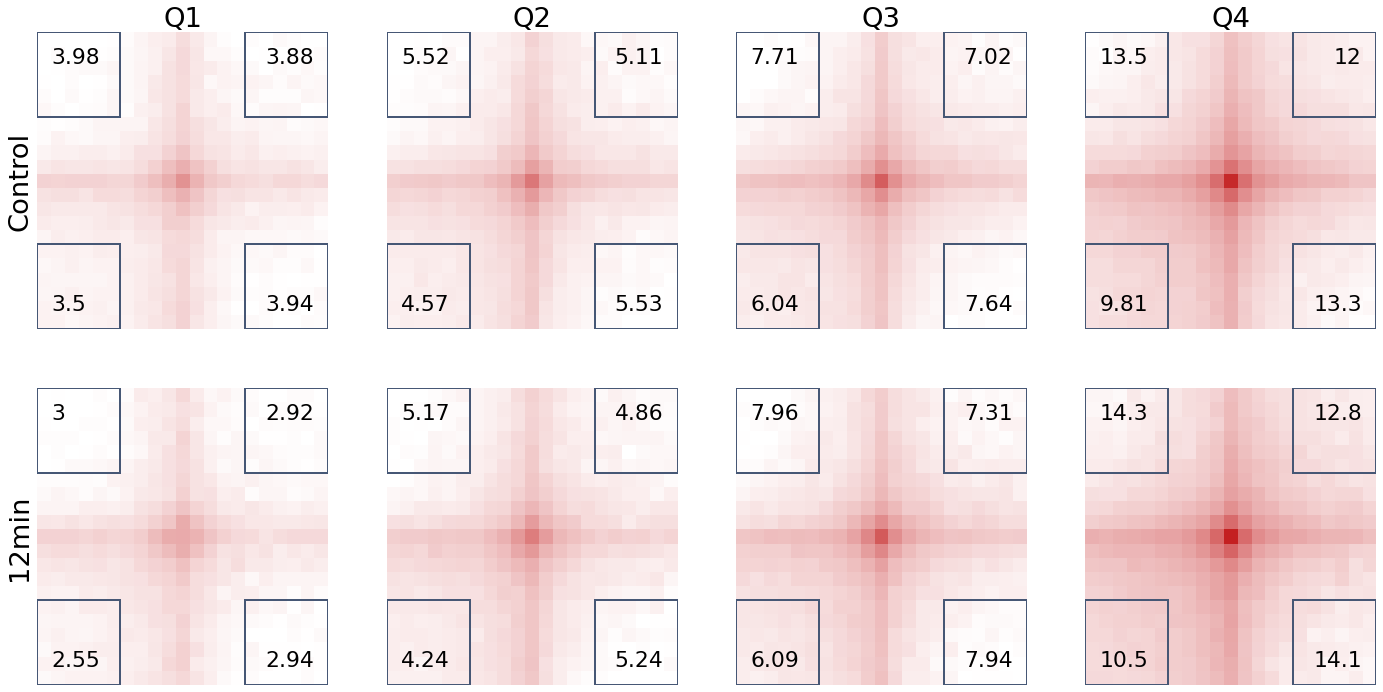

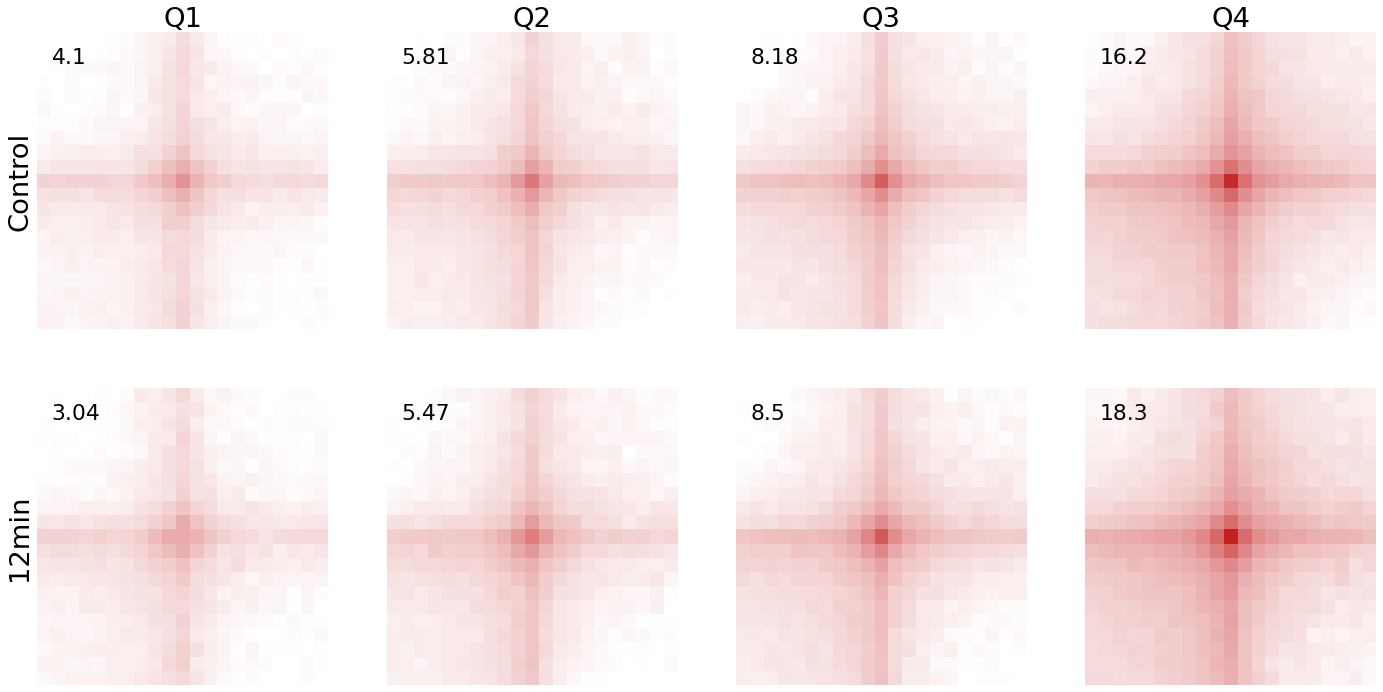

In [32]:
grid_specs = {
    'hspace': 0.01, 'wspace': 0.01
}

scores_types = ["corner_scores", "central_score"]

for scores_type in scores_types:
    fig, axs = plt.subplots(2, 4, figsize=(24, 12))
    for i, pup in enumerate(pups_common_reordered):
        for idx, ax in enumerate(axs[i, :]):
            s = sns.heatmap(
                pup.iloc[idx].data,
                cmap=cmp,
                norm=norm,
                ax=ax,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
            )
            current_type = pup.iloc[idx].loop_strength_q
            if i == 0:
                s.set_title(current_type, fontsize=2.5 * (4.94 + height))
            if idx == 0:
                s.set_ylabel(sample_names[i], fontsize=2.5 * (4.94 + height))
            mtx_size = pup.iloc[idx].data.shape[0]

            score_central = pup.central_score[idx]
            score_corner = pup.corner_scores[idx]
            if scores_type == "corner_scores":
                dots_common.add_scores(scores_type, score_corner, ax, mtx_size, corner_size, font_scale = 2, height = 6)
            elif scores_type == "central_score":
                dots_common.add_scores(scores_type, score_central, ax, mtx_size, central_size, font_scale = 2, height = 6)

    fig.savefig(f"v3/reworked_figs/supp_common_{scores_type}.svg", bbox_inches='tight')
    fig.savefig(f"v3/reworked_figs/supp_common_{scores_type}.png", dpi=300, bbox_inches='tight')

In [83]:
plot_dfs_rep = []

for i, quant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    df_now = common_loops.loc[common_loops['loop_strength_q'] == quant].copy()
    for j, data_name in enumerate(['xr-cpd-over-sim', 'xr-64-over-sim', 'dnase', 'ctcf', 'faire', 'ds-cpd-over-sim', 'ds-64-over-sim', 'rep-eff-cpd', 'rep-eff-64']):
        start_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1 - flank_size, df_now.start1, nbins_flank) / data_handlers.MEANS_BW[data_name]
        end_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom2, df_now.start2 + resolution, df_now.start2 + resolution + flank_size, nbins_flank) / data_handlers.MEANS_BW[data_name]
        main_data = bbi.stackup(data_handlers.BWS[data_name], df_now.chrom1, df_now.start1, df_now.start2 + resolution, nbins_main) / data_handlers.MEANS_BW[data_name]

        stack = np.hstack([start_data, main_data, end_data])

        stack = np.nanmean(stack, axis=0)
        stack = gaussian_filter1d(stack, 2)
        
        plot_df = pd.DataFrame(stack).melt()
        plot_df['variable'] = np.arange(plot_df.shape[0])
        plot_df['type'] = quant
        plot_df['data_name'] = data_name
        plot_dfs_rep.append(plot_df)

plot_dfs_rep = pd.concat(plot_dfs_rep).reset_index(drop=True)

In [84]:
plot_df_common_anchors = []

for i, quant in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    df_now = common_loops.loc[common_loops['loop_strength_q'] == quant].copy().reset_index(drop=True)
    anchors1 = df_now.iloc[:, :3]
    anchors1['loop_idx'] = df_now.index
    anchors2 = df_now.iloc[:, 3:6]
    anchors2['loop_idx'] = df_now.index
    anchors1.columns = ["chrom", "start", "end", "loop_idx"]
    anchors2.columns = ["chrom", "start", "end", "loop_idx"]
    all_anchors = pd.concat([anchors1, anchors2]).reset_index(drop=True)
    for j, data_name in enumerate(['dnase', 'ctcf', 'faire', 'ds-cpd-over-sim', 'ds-64-over-sim']):
        main_data = bbi.stackup(data_handlers.BWS[data_name], all_anchors.chrom, all_anchors.start, all_anchors.end, 1) 
        main_data = main_data / data_handlers.MEANS_BW[data_name] #if data_name == 'dnase' else main_data
        plot_df = pd.DataFrame(main_data).melt()
        plot_df['variable'] = np.arange(plot_df.shape[0])
        plot_df['data_name'] = data_name
        plot_df['loop_idx'] = all_anchors['loop_idx']
        plot_df['q'] = quant

        left_anchors_values = plot_df.iloc[:len(anchors1), 1].to_numpy()
        right_anchors_values = plot_df.iloc[len(anchors1):, 1].to_numpy()
        mean_vals = (left_anchors_values + right_anchors_values) / 2
        plot_df = plot_df.iloc[:len(anchors1)].copy()
        plot_df['value'] = mean_vals
        plot_df_common_anchors.append(plot_df)

plot_df_common_anchors = pd.concat(plot_df_common_anchors).reset_index(drop=True)

Q1    1621
Q2    1621
Q3    1621
Q4    1621
Name: q, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1 vs. Q2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.332e-03 U_stat=1.233e+06
Q2 vs. Q3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.925e-10 U_stat=1.303e+06
Q3 vs. Q4: Mann-Whitney-Wilcoxon test two-sided, P_val:8.344e-09 U_stat=1.287e+06
Q1    1621
Q2    1621
Q3    1621
Q4    1621
Name: q, dtype: int64
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Q1 vs. Q2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.366e-03 U_stat=1.388e+06
Q2 vs. Q3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.267e-07 U_stat=1.455e+06
Q3 vs. Q4: Mann-Whitney-Wilcoxon test two-sided, P_val:6.027e-04 U_stat=1.

/tmp/ipykernel_66315/1301708022.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


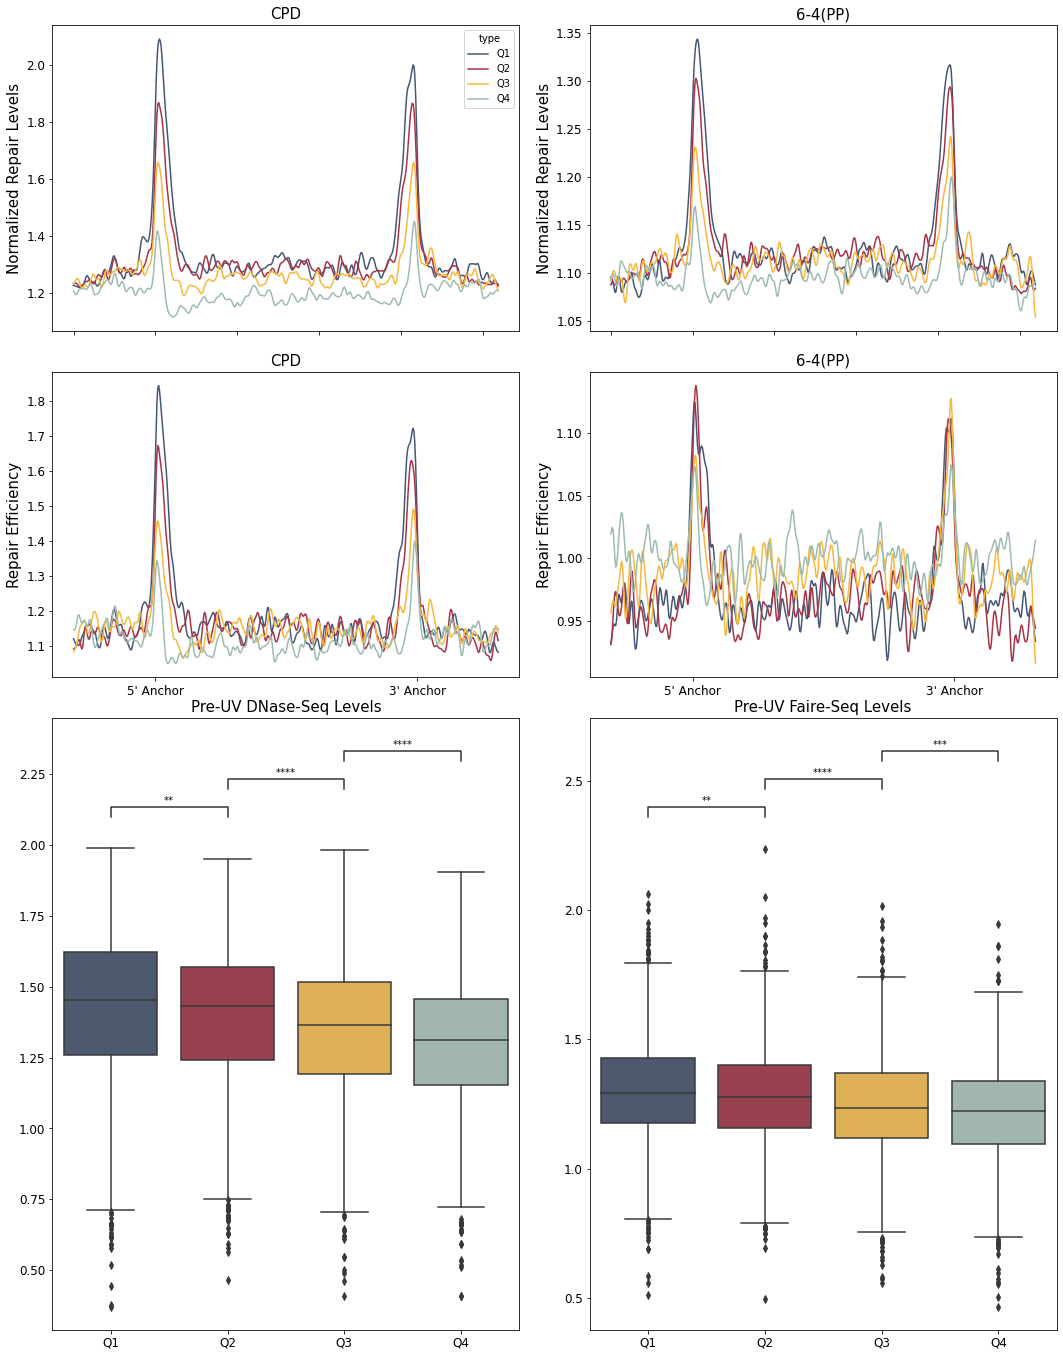

In [103]:
grid_specs = {
    'height_ratios': [.5, .5, 1],
    'width_ratios': [1, 1],
# set spacing
    'hspace': 0.1, 'wspace': .15
}

fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize=(18, 24), gridspec_kw=grid_specs, sharex='row')

s_colors = ['#465775', '#A63446', '#F5B841', '#9DBBAE']

data_name_mapping_loops = {
    'xr-cpd-over-sim' : 'CPD',
    'xr-64-over-sim' : '6-4(PP)'
}

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[0,i]
    df_now = plot_dfs_rep.loc[plot_dfs_rep['data_name'] == data_name].copy()
    sns.lineplot(data=df_now, x='variable', y='value', hue='type', ax=ax, palette=s_colors)

    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Normalized Repair Levels', fontsize=15)
    ax.set_xlabel('')

    # ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    # ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.set_xticklabels([])

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    if i!= 0:
        ax.get_legend().remove()


data_name_mapping_loops = {
    'rep-eff-cpd' : 'CPD',
    'rep-eff-64' : '6-4(PP)'
}

for i, data_name in enumerate(data_name_mapping_loops):
    ax = axs[1,i]
    df_now = plot_dfs_rep.loc[plot_dfs_rep['data_name'] == data_name].copy()
    sns.lineplot(data=df_now, x='variable', y='value', hue='type', ax=ax, palette=s_colors)

    ax.set_title(f'{data_name_mapping_loops[data_name]}', fontsize=15)
    ax.set_ylabel('Repair Efficiency', fontsize=15)
    ax.set_xlabel('')

    ax.set_xticks([nbins_flank, nbins_flank + nbins_main])
    ax.set_xticklabels(["5' Anchor", "3' Anchor"], fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    ax.get_legend().remove()

# data_name_mapping_anchors = {
#     'ds-cpd-over-sim' : 'CPD - Normalized Damage Levels',
#     'ds-64-over-sim' : '6-4PP - Normalized Damage Levels'
# }

# for i, data_name in enumerate(data_name_mapping_anchors):
#     ax = axs[i,1]
#     df_now = plot_df_common_anchors.loc[plot_df_common_anchors['data_name'] == data_name].copy()

#     sns.boxplot(data=df_now, x='q', y='value', ax=ax, showfliers=False, palette=s_colors)

#     pairs = [('Q1', 'Q2'), ('Q1', 'Q3'), ('Q1', 'Q4'), ('Q2', 'Q3'), ('Q2', 'Q4'), ('Q3', 'Q4')]
    
#     from statannotations.Annotator import Annotator

#     annotator = Annotator(ax, pairs, data=df_now, x='q', y='value')
#     annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#     annotator.apply_and_annotate()

#     ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
#     ax.set_ylabel('')
#     ax.set_xlabel('')

#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax.tick_params(axis='both', which='minor', labelsize=12)

data_name_mapping_anchors = {
    'dnase' : 'Pre-UV DNase-Seq Levels',
    'faire' : 'Pre-UV Faire-Seq Levels'
}

for i, data_name in enumerate(data_name_mapping_anchors):
    ax = axs[2,i]

    df_now = plot_df_common_anchors.loc[plot_df_common_anchors['data_name'] == data_name].copy()
    print(df_now.q.value_counts())
    
    sns.boxplot(data=df_now, x='q', y='value', ax=ax, showfliers=True, palette=s_colors)

    #pairs = [('Q1', 'Q2'), ('Q1', 'Q3'), ('Q1', 'Q4'), ('Q2', 'Q3'), ('Q2', 'Q4'), ('Q3', 'Q4')]
    # no need for all combinations, just compare the adjacent ones since they are naturally ordered
    pairs = [('Q1', 'Q2'), ('Q2', 'Q3'), ('Q3', 'Q4')]

    from statannotations.Annotator import Annotator

    annotator = Annotator(ax, pairs, data=df_now, x='q', y='value')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
    annotator.apply_and_annotate()

    ax.set_title(f'{data_name_mapping_anchors[data_name]}', fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

plt.tight_layout()

fig.savefig("v3/reworked_figs/supp_rep.svg", bbox_inches='tight')
fig.savefig("v3/reworked_figs/supp_rep.png", dpi=300, bbox_inches='tight')

### Overlaps

In [39]:
samples_df = {k: [] for k in samples}
import itertools
for i, (c1, c2) in enumerate(list(itertools.permutations(samples, 2))):
    print(c1, c2)
    idx_sample_i = samples.index(c1)
    idx_sample_j = samples.index(c2)
    dots_df_i = dots_df_[idx_sample_i].copy()
    dots_df_j = dots_df_[idx_sample_j].copy()
    
    loops, anchors = _2_step_loop_separation(
        dots_df_i, dots_df_j, 
        clrs_[idx_sample_i], clrs_[idx_sample_j],
        expected_[idx_sample_i], expected_[idx_sample_j],
        view_df=hg38_arms, 
        merge_common = True, accepted_range=accepted_range, threshold = threshold)
    loops_common = loops['common_loops']
    loops_common['end1'] = loops_common['start1'] + resolution
    loops_common['end2'] = loops_common['start2'] + resolution

    loops_specific1 = loops['specific_loops1']
    loops_specific1['end1'] = loops_specific1['start1'] + resolution
    loops_specific1['end2'] = loops_specific1['start2'] + resolution

    loops_common['type'] = 'common_loops'
    loops_specific1['type'] = 'specific_loops1'
    samples_df[c1].append(pd.concat([loops_common.iloc[:, [0,1,2,3,4,5,-1]], loops_specific1.iloc[:, [0,1,2,3,4,5,-1]]]))

t0 t12


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t0 t30


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t0 t60


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t12 t0


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t12 t30


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t12 t60


/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t30 t0


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t30 t12


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t30 t60


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t60 t0


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t60 t12


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2
t60 t30


/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


In [40]:
dots_df_now = []

for k,v in samples_df.items():
    dots_df_now.append(pd.concat(v).copy().iloc[:, :6].drop_duplicates()[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2',]])

In [41]:
import itertools

all_loops_per_sample = []
#for i, df in enumerate(dots_df_):
for i, df in enumerate(dots_df_now):
    loops_now = df.iloc[:, :6].copy()
    all_loops_per_sample.append(loops_now)

flank = accepted_range

all_sample_ranges = []
for i, loop_df in enumerate(all_loops_per_sample):
    per_sample_ranges = {chrom: [] for chrom in clrs_[0].chromnames}
    for idx, row in loop_df.iterrows():
        r1 = range(row['start1'] - flank, row['end1'] + flank)
        r2 = range(row['start2'] - flank, row['end2'] + flank)
        per_sample_ranges[row['chrom1']].append((r1,r2, idx))
    all_sample_ranges.append(per_sample_ranges)

In [42]:
all_loops_found = [[[] for i in range(len(dots_df_[k]))] for k in range(4)]

import tqdm
for i, (c1, c2) in enumerate(itertools.combinations(range(4), 2)):
    print(c1,c2)
    current_ranges = all_sample_ranges[c1]
    for idx, row in tqdm.tqdm(all_loops_per_sample[c2].iterrows(), total=all_loops_per_sample[c2].shape[0]):
        midpoint1 = (row['start1'] + row['end1']) // 2
        midpoint2 = (row['start2'] + row['end2']) // 2
        chrom_now = row['chrom1']
        c2_idx = idx
        for r_now in current_ranges[chrom_now]:
            c1_idx = r_now[2]
            if midpoint1 in r_now[0] and midpoint2 in r_now[1]:
                all_loops_found[c1][c1_idx].append(c2)


for i, n in enumerate(all_loops_found):
    for j, m in enumerate(n):
        all_loops_found[i][j] = list(set(m))

0 1


100%|██████████| 8729/8729 [00:00<00:00, 14750.47it/s]


0 2


100%|██████████| 11381/11381 [00:00<00:00, 14514.99it/s]


0 3


100%|██████████| 9152/9152 [00:00<00:00, 15109.15it/s]


1 2


100%|██████████| 11381/11381 [00:00<00:00, 15973.89it/s]


1 3


100%|██████████| 9152/9152 [00:00<00:00, 15650.68it/s]


2 3


100%|██████████| 9152/9152 [00:00<00:00, 12780.02it/s]


In [43]:
deseq_lrt = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/all_deseq_lrt.tsv", sep="\t")
deseq_lrt.rename(columns={'gene_id': 'ensembl_gene_id'}, inplace=True)
deseq_lrt['chromosome_name'] = [f"chr{chrom}" for chrom in deseq_lrt['chromosome_name']]
deseq_lrt = deseq_lrt[['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'padj']]
deseq_lrt.rename(columns={'chromosome_name': 'chrom', 'start_position': 'start', 'end_position': 'end', 'external_gene_name': 'gene_name'}, inplace=True)
deseq_lrt.start = deseq_lrt.start.astype(int)
deseq_lrt.end = deseq_lrt.end.astype(int)

deseq_lrt.sort_values('padj', inplace=True)
deseq_lrt.dropna(subset=['gene_name'], inplace=True)

In [44]:
anchor_flank = accepted_range

all_anchors_per_sample = []
for i, df in enumerate(dots_df_):
    loops_now = df.iloc[:, :6].copy()
    loops_now['loop_presence'] = all_loops_found[i]
    left_anchors = loops_now.iloc[:, [0,1,2,-1]].copy()
    right_anchors = loops_now.iloc[:, [3,4,5,-1]].copy()
    left_anchors.columns = ['chrom', 'start', 'end', 'loop_presence']
    right_anchors.columns = ['chrom', 'start', 'end', 'loop_presence']
    left_anchors['loop_idx'] = left_anchors.index
    right_anchors['loop_idx'] = right_anchors.index
    left_anchors['start'] = left_anchors['start'] - anchor_flank
    left_anchors['end'] = left_anchors['end'] + anchor_flank
    right_anchors['start'] = right_anchors['start'] - anchor_flank
    right_anchors['end'] = right_anchors['end'] + anchor_flank
    
    all_anchors = pd.concat([left_anchors, right_anchors]).reset_index(drop=True)
    all_anchors_per_sample.append(all_anchors)

goi_data = {}
top_N = 25
for goi in deseq_lrt.gene_name.unique():
    goi_arr = []
    for i, df in enumerate(all_anchors_per_sample):
        overlap = bioframe.overlap(df, deseq_lrt, return_index=True).dropna(subset=['chrom_'])
        all_l = []
        for l in overlap.loc[overlap['gene_name_'] == goi].loop_presence.to_list():
            
            if len(l) == 3: # present in all samples
                continue
            if len(l) == 0:
                continue
            if len(l) > 0:
                new_l = l + [i]
                all_l.append(new_l)
        all_l = [list(t) for t in set(tuple(lst) for lst in all_l)]
        for l_now in all_l:
            goi_arr.append(sorted(l_now))

    mtx = np.zeros((len(goi_arr), 4))
    for i, l_now in enumerate(goi_arr):
        for s in l_now:
            mtx[i,s] = 1
    
    if np.sum(mtx) != 0:
        goi_data[goi] = mtx
    if len(goi_data) == top_N:
        break

In [45]:
goi_data = {k: v for k,v in goi_data.items() if v.shape[0] > 0}

In [46]:
topGenes = list(goi_data.keys())

/tmp/ipykernel_66315/2751529880.py:55: RuntimeWarning: divide by zero encountered in log10
  minus_log10_padj = -np.log10(padj)
/tmp/ipykernel_66315/2751529880.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  b1.set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
/tmp/ipykernel_66315/2751529880.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  b2.set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
/tmp/ipykernel_66315/2751529880.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


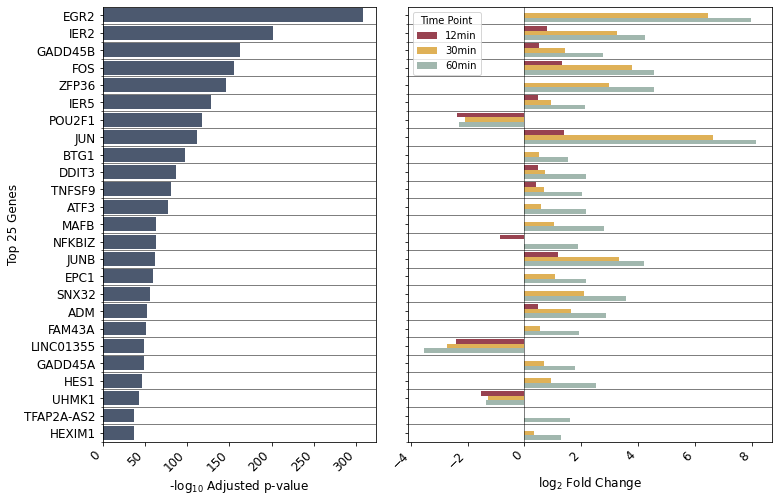

In [47]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=1, sharey="row",
 gridspec_kw={"wspace": 0.1, 'width_ratios': [3, 4]})

degs_0_12 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t12.degs.tsv", sep="\t")
degs_0_60 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t60.degs.tsv", sep="\t")
degs_0_30 = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/t0-t30.degs.tsv", sep="\t")

topN_now = 25
deseq_lrt = pd.read_csv("/home/carlos/oldies/manuscripts/notebooks/RNA/all_deseq_lrt.tsv", sep="\t")
deseq_lrt.rename(columns={'gene_id': 'ensembl_gene_id'}, inplace=True)
deseq_lrt_intersect_topN = deseq_lrt.loc[deseq_lrt.external_gene_name.isin(topGenes)].sort_values(by='padj').head(topN_now)

plot_dict_FC = {
    "geneName": [],
    "Fold Change": [],
    "Time Point": []
}

fc_12 = degs_0_12.loc[degs_0_12.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]
fc_30 = degs_0_30.loc[degs_0_30.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]
fc_60 = degs_0_60.loc[degs_0_60.ensembl_gene_id.isin(deseq_lrt_intersect_topN.ensembl_gene_id.values)]

plot_dict_padj = {
    "geneName": [],
    "padj": [],
}

for gene in deseq_lrt_intersect_topN.external_gene_name.values:
    
    plot_dict_FC["geneName"].append(gene)
    plot_dict_FC["geneName"].append(gene)
    plot_dict_FC["geneName"].append(gene)


    if gene not in fc_12.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_12.loc[fc_12.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("12min")

    if gene not in fc_30.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_30.loc[fc_30.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("30min")

    if gene not in fc_60.external_gene_name.values:
        plot_dict_FC["Fold Change"].append(0)
    else:
        plot_dict_FC["Fold Change"].append(fc_60.loc[fc_60.external_gene_name == gene].log2FoldChange.values[0])
    plot_dict_FC["Time Point"].append("60min")

    plot_dict_padj["geneName"].append(gene)
    padj = deseq_lrt_intersect_topN.loc[deseq_lrt_intersect_topN.external_gene_name == gene].padj.values[0]
    minus_log10_padj = -np.log10(padj)
    if minus_log10_padj == np.inf:
        minus_log10_padj = 308
    plot_dict_padj["padj"].append(minus_log10_padj)


plot_df_FC = pd.DataFrame(plot_dict_FC)
plot_df_padj = pd.DataFrame(plot_dict_padj)

b1 = sns.barplot(x="padj", y="geneName", data=plot_df_padj, ax=ax[0], palette=["#465775"])
b1.set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
b1.set_ylabel(f"Top {topN_now} Genes", fontsize=12)
b1.set_xlabel(f"-log$_{{10}}$ Adjusted p-value", fontsize=12)
b1.tick_params(axis='both', which='major', labelsize=12)
b1.tick_params(axis='both', which='minor', labelsize=12)

b2 = sns.barplot(x="Fold Change", y="geneName", hue="Time Point", data=plot_df_FC, ax=ax[1], palette=['#A63446', "#F5B841", '#9DBBAE'])
b2.set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=20)
b2.set_ylabel("")
b2.set_xlabel("Gene Name")
b2.axvline(x=0, color='black', linestyle='-', lw=0.5)
b2.tick_params(axis='both', which='major', labelsize=12)
b2.tick_params(axis='both', which='minor', labelsize=12)
b2.set_xlabel(f"log$_{{2}}$ Fold Change", fontsize=12) 

# Calculate the number of bars
num_bars = len(plot_df_FC['geneName'].unique())
# Calculate the y-tick locations
y_ticks = np.arange(num_bars)
# Set the y-ticks
ax[0].set_yticks(y_ticks)
ax[1].set_yticks(y_ticks)
# Get the unique gene names
gene_names = plot_df_FC['geneName'].unique()
# Set the y-tick labels back to the gene names
ax[0].set_yticklabels(gene_names)
ax[1].set_yticklabels(gene_names)
# Add grid lines at halfway points
ax[0].set_yticks(y_ticks + 0.5, minor=True)
ax[1].set_yticks(y_ticks + 0.5, minor=True)
ax[0].grid(axis='y', which='minor', linestyle='-', alpha=1, lw=.5, color="black")
ax[1].grid(axis='y', which='minor', linestyle='-', alpha=1, lw=.5, color="black")
ax[1].set_yticklabels(gene_names)

fig.tight_layout()
fig.savefig(f"v3/reworked_figs/FC_padj.png", dpi=300, facecolor="white", edgecolor='none')
fig.savefig(f"v3/reworked_figs/FC_padj.svg", facecolor="white", edgecolor='none')

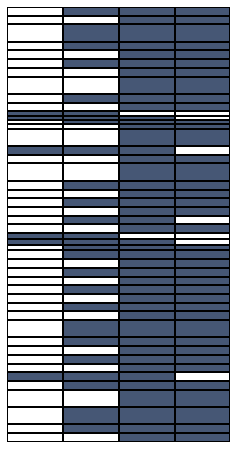

In [48]:
fig2, ax_hm = plt.subplots(figsize=(4, 8), ncols=1, nrows=topN_now, gridspec_kw={"hspace": 0}, sharex=True)

from matplotlib.colors import LinearSegmentedColormap
#cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "#465775"], N=256)
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "#465775"], N=256)

for idx, (k,v) in enumerate(goi_data.items()):
    s = sns.heatmap(v, ax=ax_hm[idx], cmap=cmp, cbar=False, yticklabels=False, xticklabels=False, linecolor='black', linewidth=0.1)

fig2.savefig(f"v3/reworked_figs/heatmap_topN.png", dpi=300, facecolor="white", edgecolor='none')
fig2.savefig(f"v3/reworked_figs/heatmap_topN.svg", facecolor="white", edgecolor='none')

### Volcano Plots - Spec2 Loops ~ RNA-Seq

In [49]:
loops, anchors = _2_step_loop_separation(
    dots_df_[0], dots_df_[1], 
    clrs_[0], clrs_[1],
    expected_[0], expected_[1],
    view_df=hg38_arms,
    merge_common = True, accepted_range=accepted_range, threshold = threshold, nproc=nproc, resolution=resolution)

from dots_common import make_loops_df, make_anchors_df
loops_df = make_loops_df(loops, resolution=10_000)
anchors_df = make_anchors_df(anchors, resolution=10_000)

/home/carlos/oldies/manuscripts/review/dots_common.py:284: RuntimeWarning: divide by zero encountered in divide
  diff = pup_0_cs / pup_1_cs
/home/carlos/oldies/manuscripts/review/dots_common.py:287: RuntimeWarning: divide by zero encountered in divide
  diff = pup_1_cs / pup_0_cs


End of step1: Merging common_loops1 with specific_loops1
End of step1: Merging common_loops2 with specific_loops2


In [50]:
deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t12.all..tsv', sep='\t')
deseq_all.chrom = [f"chr{chrom}" for chrom in deseq_all.chrom]
deseq_all.start = deseq_all.start.astype(int)
deseq_all.end = deseq_all.end.astype(int)
deseq_all = deseq_all[['chrom', 'start', 'end', 'external_gene_name', 'strand']]

flank = 20_000

anchors_df['start'] = (anchors_df.start - flank).astype(int)
anchors_df['end'] = (anchors_df.end + flank).astype(int)


overlap_df = bioframe.overlap(deseq_all, anchors_df)
overlap_df.dropna(inplace=True)
specific_anchors2 = overlap_df.copy()

GADD45B 2.75807472075058 48.92193880594272
CCN2 4.27586933937646 149.95211778766495
DUSP1 3.22925867875565 51.07839751861897
FOSB 6.56386384817897 134.39579049098208
ZFP36 4.55419096927456 91.08987217503505
SAT1 2.81683202553791 46.07033079199145
IL6 3.19528949298452 34.97847391568033
IER3 3.12611948618954 97.33591438169996
ADM 2.87939460591501 25.48311650480248
IER2 4.22748351800094 223.7117396009177
FOS 4.55382917507356 221.27580427330136
JUNB 4.19612074685747 112.34925106478128
JUN 8.14282612967314 300.0
IER3-AS1 3.4473814724437 31.194248887213014
LINC00602 3.51684521661226 42.45786762451327


/tmp/ipykernel_66315/3844556705.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)


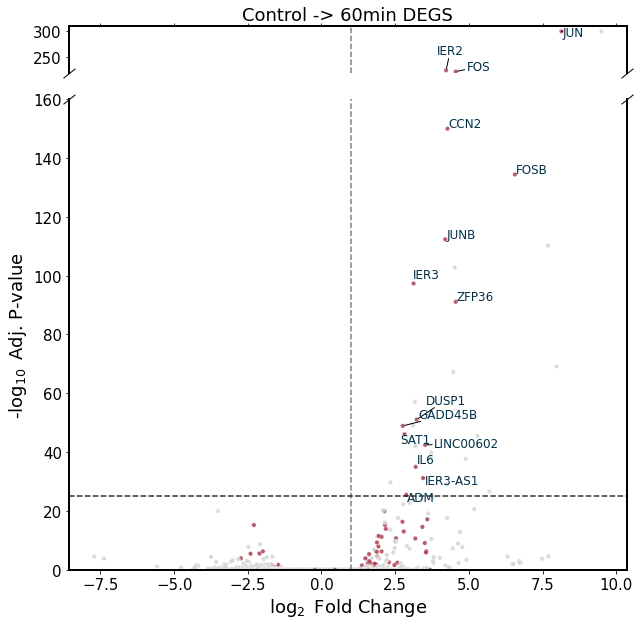

In [69]:
deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t60.all..tsv', sep='\t')
#deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t12.all..tsv', sep='\t')

deseq_all['chrom'] = "chr" + deseq_all['chrom']
df = deseq_all.copy()
df.rename(columns={'ensembl_gene_id': 'gene_id'}, inplace=True)

overlap_specific2 = specific_anchors2.copy()
overlap_specific2_gene_id = overlap_specific2['external_gene_name'].unique().tolist()

fdr_cutoff = 0.05
l2fc_cutoff = 1

#log_fdr_cutoff = -np.log10(fdr_cutoff)
log_fdr_cutoff = 25

height_ratio = [0.1, 1]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10), gridspec_kw={'hspace': .1, 'height_ratios': height_ratio})

#spec1 = df.loc[df['gene_id'].isin(overlap_specific1_gene_id)]
spec2 = df.loc[df['external_gene_name'].isin(overlap_specific2_gene_id)]

which_df = spec2.copy()

plot_df = df.copy()
plot_df['color_group'] = 'other'
plot_df.loc[plot_df['external_gene_name'].isin(which_df.external_gene_name.to_list()), 'color_group'] = 'specific'
plot_df.loc[(plot_df.padj < fdr_cutoff) & (plot_df.color_group != 'specific'), 'color_group'] = 'other'

plot_df.loc[plot_df.padj == 0, 'padj'] = 1e-300
plot_df['padj'] = plot_df['padj'].apply(lambda x:-np.log10(x))

plot_df.color_group = pd.Categorical(plot_df.color_group, categories=['specific', 'other'])

cut_points = [160, 218, 310]


plot_df_ax1 = plot_df.loc[plot_df['padj'] > cut_points[1]]
plot_df_ax2 = plot_df.loc[plot_df['padj'] < cut_points[0]]
sns.scatterplot(data=plot_df_ax1, x='log2FoldChange', y='padj', hue='color_group', ax=ax1, palette=['#A63446', 'lightgray'], s=20, alpha=0.8)
sns.scatterplot(data=plot_df_ax2, x='log2FoldChange', y='padj', hue='color_group', ax=ax2, palette=['#A63446', 'lightgray'], s=20, alpha=0.8)
# delete legend
ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.set_ylim(cut_points[1], cut_points[2])  # outliers only
ax2.set_ylim(0, cut_points[0])  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

x_offset_m = (-.1, .1)
y_offset_m = (-1, 1)

text1, text2 = [], []
for i,r in plot_df.iterrows():
    if r['padj'] > log_fdr_cutoff and abs(r['log2FoldChange']) > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] < cut_points[0]:
        print(r['external_gene_name'], r['log2FoldChange'], r['padj'])
        text2.append(ax2.text(x = r['log2FoldChange'],
                 y = r['padj'],
                 s = r['external_gene_name'], fontsize=12, color = '#003049'))
    elif r['padj'] > log_fdr_cutoff and abs(r['log2FoldChange']) > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] > cut_points[1]:
        
        print(r['external_gene_name'], r['log2FoldChange'], r['padj'])
        text1.append(ax1.text(x = r['log2FoldChange'], 
                 y = r['padj'],
                 s=r['external_gene_name'], fontsize=12, color = '#003049'))

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

ax1.axvline(l2fc_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axhline(log_fdr_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axvline(l2fc_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axhline(log_fdr_cutoff,color="black",linestyle="--", alpha=0.5)

ax1.set_xlabel('')
ax1.set_ylabel('')
#ax2.set_ylabel('-log FDR', fontsize=15)
# make "log" subscript
ax2.set_ylabel(r'-$\log_{10}$ Adj. P-value', fontsize=18)
ax2.set_xlabel(r'$\log_{2}$ Fold Change', fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

ax1.set_title('Control -> 60min DEGS', fontsize=18)

from adjustText import adjust_text

adjust_text(text1, arrowprops = dict(arrowstyle = '-', color = 'k'), ax=ax1)
adjust_text(text2, arrowprops = dict(arrowstyle = '-', color = 'k'), ax=ax2)

fig.savefig('/home/carlos/oldies/manuscripts/review/v3/reworked_figs/volcano_t060rna_t012spec2.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/carlos/oldies/manuscripts/review/v3/reworked_figs/volcano_t060rna_t012spec2.svg', bbox_inches='tight')

/tmp/ipykernel_66315/1474205657.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)


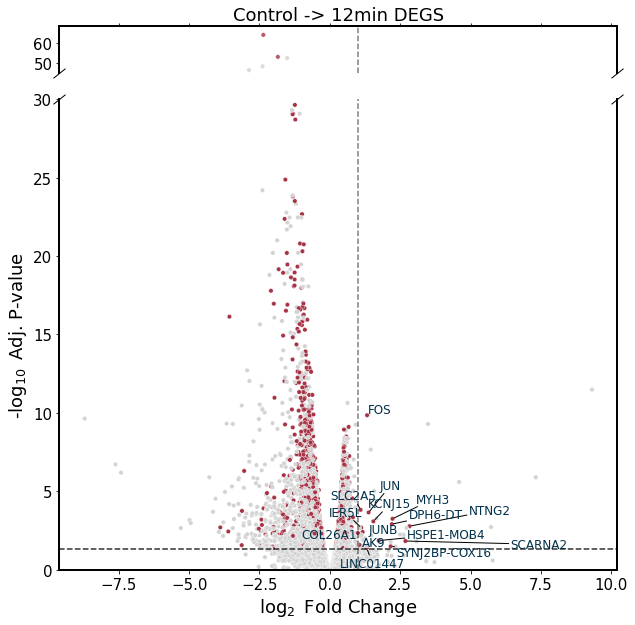

In [70]:
deseq_all = pd.read_csv('/home/carlos/oldies/manuscripts/review/t0-t12.all..tsv', sep='\t')

deseq_all['chrom'] = "chr" + deseq_all['chrom']
df = deseq_all.copy()
df.rename(columns={'ensembl_gene_id': 'gene_id'}, inplace=True)

overlap_specific2 = specific_anchors2.copy()
overlap_specific2_gene_id = overlap_specific2['external_gene_name'].unique().tolist()


fdr_cutoff = 0.05
l2fc_cutoff = 1
log_fdr_cutoff = -np.log10(fdr_cutoff)
#log_fdr_cutoff = 2

height_ratio = [0.1, 1]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10), gridspec_kw={'hspace': .1, 'height_ratios': height_ratio})

spec2 = df.loc[df['external_gene_name'].isin(overlap_specific2_gene_id)]

which_df = spec2.copy()

plot_df = df.copy()
plot_df['color_group'] = 'other'
plot_df.loc[(plot_df['external_gene_name'].isin(which_df.external_gene_name.to_list())) & (plot_df.padj < 0.05), 'color_group'] = 'specific'


plot_df['padj'] = plot_df['padj'].apply(lambda x:-np.log10(x))

plot_df.color_group = pd.Categorical(plot_df.color_group, categories=['specific', 'other'])



cut_points = [30, 45, 68]

plot_df_ax1 = plot_df.loc[plot_df['padj'] > cut_points[1]]
plot_df_ax2 = plot_df.loc[plot_df['padj'] < cut_points[0]]
sns.scatterplot(data=plot_df_ax1, x='log2FoldChange', y='padj', hue='color_group', ax=ax1, palette=['#A63446', 'lightgrey'], s=20, alpha=0.8)
sns.scatterplot(data=plot_df_ax2, x='log2FoldChange', y='padj', hue='color_group', ax=ax2, palette=['#A63446', 'lightgrey'], s=20)

# delete legend
ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.set_ylim(cut_points[1], cut_points[2])  # outliers only
ax2.set_ylim(0, cut_points[0])  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

text1 = []
text2 = []

for i,r in plot_df.iterrows():
    x_offset = np.random.uniform(*x_offset_m)
    y_offset = np.random.uniform(*y_offset_m)
    if r['padj'] > log_fdr_cutoff and r['log2FoldChange'] > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] < cut_points[0]:
        text2.append(ax2.text(x = r['log2FoldChange'],
                 y = r['padj'],
                 s = r['external_gene_name'], fontsize=12, color = '#003049'))
    elif r['padj'] > log_fdr_cutoff and r['log2FoldChange'] > l2fc_cutoff and r['color_group'] == 'specific' and r['padj'] > cut_points[1]:
        text1.append(ax1.text(x = r['log2FoldChange'], 
                 y = r['padj'],
                 s=r['external_gene_name'], fontsize=12, color = '#003049'))
        
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

ax1.axvline(l2fc_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axhline(log_fdr_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axvline(l2fc_cutoff,color="black",linestyle="--", alpha=0.5)
ax2.axhline(log_fdr_cutoff,color="black",linestyle="--", alpha=0.5)

ax1.set_xlabel('')
ax1.set_ylabel('')
#ax2.set_ylabel('-log FDR', fontsize=15)
# make "log" subscript
ax2.set_ylabel(r'-$\log_{10}$ Adj. P-value', fontsize=18)
ax2.set_xlabel(r'$\log_{2}$ Fold Change', fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

ax1.set_title('Control -> 12min DEGS', fontsize=18)

from adjustText import adjust_text

adjust_text(text1, arrowprops = dict(arrowstyle = '-', color = 'k'), ax=ax1)
adjust_text(text2, arrowprops = dict(arrowstyle = '-', color = 'k'), ax=ax2)

fig.savefig('/home/carlos/oldies/manuscripts/review/v3/reworked_figs/volcano_t012rna_t012spec2.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/carlos/oldies/manuscripts/review/v3/reworked_figs/volcano_t012rna_t012spec2.svg', bbox_inches='tight')